In [ ]:
!pip install wandb

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!ls -a ~/.kaggle

.  ..  kaggle.json


In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer
!unzip emotion-detection-fer.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
wandb.init(project="EmotionDetection_v5")

In [ ]:
width = height = 64
batch_size = 32

In [ ]:
train_dataset_path = "/content/train"

idg = ImageDataGenerator(
    rescale = 1./255,

    #Augmentation
    horizontal_flip = True,
    brightness_range = (0.8, 1.2),
    shear_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    validation_split = 0.2
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "training"
)

val_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


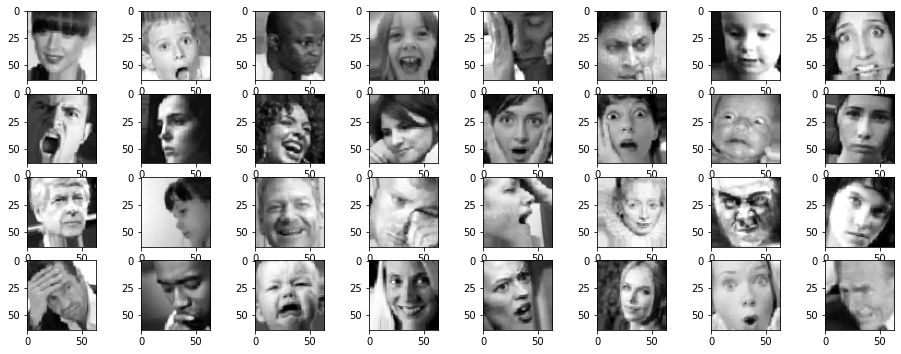

In [ ]:
X, _ = next(train_data)
plt.figure(figsize=(16, 12))
for i in range(batch_size):
    plt.subplot(8, 8, i+1)
    plt.imshow(X[i, :, :, 0], cmap="gray")

In [ ]:
for image_batch in train_data:
    print(image_batch[0].shape)
    break

(32, 64, 64, 1)


In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(64, 64, 1)),
    Conv2D(64, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(128, (3, 3), padding="same", activation='relu'),
    Conv2D(128, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(512, (3, 3), padding="same", activation='relu'),
    Conv2D(512, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(512, (5, 5), padding="same", activation='relu'),
    Conv2D(512, (5, 5), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(128, (3, 3), padding="same", activation='relu'),
    Conv2D(128, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dropout(0.6),
    Dense(1024, activation="relu"),
    Dropout(0.5),
    Dense(7, activation="softmax")
    ])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 conv2d_40 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_20 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 128)      

In [ ]:
config = wandb.config
config.learning_rate = 0.0001
checkpoint_filepath = "/content/drive/MyDrive/Emotion Detection/model/model_v2.h5"

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=["accuracy"])

In [ ]:
model.fit(train_data, validation_data=val_data, epochs=60, callbacks=[WandbCallback(), model_checkpoint_callback])

Epoch 1/60
718/718 [==============================] - 65s 89ms/step - loss: 1.9927 - accuracy: 0.2022 - val_loss: 1.8147 - val_accuracy: 0.2513 - _timestamp: 1651608516.0000 - _runtime: 77.0000
Epoch 2/60
718/718 [==============================] - 61s 85ms/step - loss: 1.8436 - accuracy: 0.2297 - val_loss: 1.8178 - val_accuracy: 0.2513 - _timestamp: 1651608580.0000 - _runtime: 141.0000
Epoch 3/60
718/718 [==============================] - 61s 84ms/step - loss: 1.8298 - accuracy: 0.2406 - val_loss: 1.8313 - val_accuracy: 0.2513 - _timestamp: 1651608641.0000 - _runtime: 202.0000
Epoch 4/60
718/718 [==============================] - 61s 84ms/step - loss: 1.8258 - accuracy: 0.2441 - val_loss: 1.8280 - val_accuracy: 0.2513 - _timestamp: 1651608701.0000 - _runtime: 262.0000
Epoch 5/60
718/718 [==============================] - 61s 85ms/step - loss: 1.8208 - accuracy: 0.2447 - val_loss: 1.8312 - val_accuracy: 0.2513 - _timestamp: 1651608762.0000 - _runtime: 323.0000
Epoch 6/60
718/718 [======

In [ ]:
model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[WandbCallback(), model_checkpoint_callback])

Epoch 1/10
718/718 [==============================] - 60s 84ms/step - loss: 0.7540 - accuracy: 0.7286 - val_loss: 1.0186 - val_accuracy: 0.6339 - _timestamp: 1651612348.0000 - _runtime: 3909.0000
Epoch 2/10
718/718 [==============================] - 61s 84ms/step - loss: 0.7402 - accuracy: 0.7328 - val_loss: 0.9675 - val_accuracy: 0.6576 - _timestamp: 1651612409.0000 - _runtime: 3970.0000
Epoch 3/10
718/718 [==============================] - 61s 84ms/step - loss: 0.7451 - accuracy: 0.7311 - val_loss: 0.9938 - val_accuracy: 0.6441 - _timestamp: 1651612470.0000 - _runtime: 4031.0000
Epoch 4/10
718/718 [==============================] - 61s 84ms/step - loss: 0.7350 - accuracy: 0.7381 - val_loss: 0.9847 - val_accuracy: 0.6464 - _timestamp: 1651612530.0000 - _runtime: 4091.0000
Epoch 5/10
718/718 [==============================] - 61s 85ms/step - loss: 0.7163 - accuracy: 0.7411 - val_loss: 0.9623 - val_accuracy: 0.6502 - _timestamp: 1651612591.0000 - _runtime: 4152.0000
Epoch 6/10
718/718 [

In [ ]:
test_dataset_path = "/content/test"

idg = ImageDataGenerator(
    rescale = 1./255
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = "grayscale",
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [ ]:
model.evaluate(test_data)

225/225 [==============================] - 5s 22ms/step - loss: 0.9666 - accuracy: 0.6601


[0.9666303396224976, 0.6600724458694458]

In [ ]:
true_labels = test_data.classes
predictions = model.predict(test_data)

In [ ]:
predictions_label = np.array([np.argmax(x) for x in predictions])

In [ ]:
predictions_label

array([0, 4, 4, ..., 6, 6, 4])

In [ ]:
cf_matrix = confusion_matrix(true_labels, predictions_label)

In [ ]:
cf_matrix

array([[ 553,   28,   75,   43,  124,  123,   12],
       [  31,   61,    7,    3,    3,    6,    0],
       [ 124,   18,  438,   31,  127,  204,   82],
       [  29,    1,   29, 1559,  102,   27,   27],
       [  59,    4,   54,   82,  863,  156,   15],
       [  93,    9,  111,   78,  276,  662,   18],
       [  31,    4,  104,   44,   35,   11,  602]])

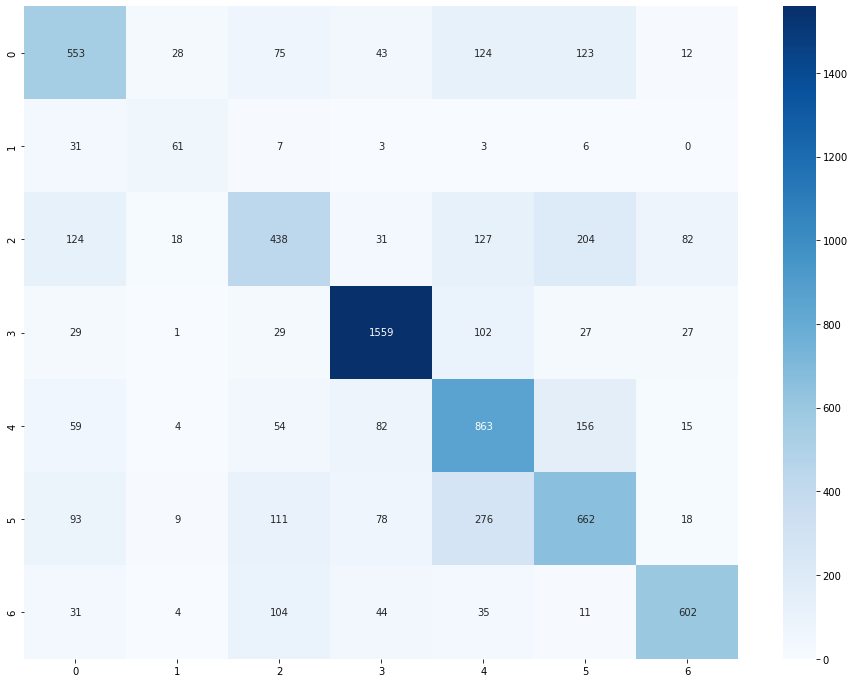

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')

In [ ]:
model.save("/content/drive/MyDrive/Emotion Detection/model/model_v3.h5")